# New LRISr Mark4 detector

In [11]:
# imports
import os, glob
import numpy as np

from matplotlib import pyplot as plt

from astropy.io import fits

from pypeit.core import parse
from pypeit.display import display
from pypeit import flatfield

# Load data

In [2]:
dpath = '/scratch/REDUX/Keck/LRIS/new_LRISr'
rpath = os.path.join(dpath, 'Raw')

In [9]:
dfile = os.path.join(rpath, 'r211004_00003.fits')

In [4]:
hdul = fits.open(dfile)

In [5]:
hdul.info()

Filename: /scratch/REDUX/Keck/LRIS/new_LRISr/Raw/r211004_00003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     344   (4234, 4248)   int16 (rescales to uint16)   
  1  Exposure Events    1 TableHDU        17   3R x 2C   [A26, A80]   


In [6]:
raw_data = hdul[0].data.astype(float)

In [7]:
raw_data.shape

(4248, 4234)

# Load pixel file

In [12]:
pix_file = os.path.join(dpath, 'pixelsL2U2L1U1_1_1.fits')

In [13]:
hdu_pix = fits.open(pix_file)
hdu_pix.info()

Filename: /scratch/REDUX/Keck/LRIS/new_LRISr/pixelsL2U2L1U1_1_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     217   (4234, 4248)   int16   


In [32]:
for ii in range(4):
    print(hdu_pix[0].header[f'DSEC{ii}'])

[8:2064,2185:4248]
[8:2064,1:2064]
[2171:4227,2185:4248]
[2171:4227,1:2064]


# Overwrite header

In [14]:
head0 = hdul[0].header

In [17]:
for card, value in hdu_pix[0].header.items():
    head0[card] = value

## Write

In [21]:
hdul[0].header['BSEC4']

'[2170:2118,4248:2185]'

In [22]:
hdul.writeto(dfile.replace('.fits', '_upd.fits'))

# Loop me

In [27]:
rfiles = glob.glob(rpath+'/*.fits')
rfiles

['/scratch/REDUX/Keck/LRIS/new_LRISr/Raw/r211004_00006.fits',
 '/scratch/REDUX/Keck/LRIS/new_LRISr/Raw/r211004_00003.fits',
 '/scratch/REDUX/Keck/LRIS/new_LRISr/Raw/r211004_00008.fits',
 '/scratch/REDUX/Keck/LRIS/new_LRISr/Raw/r211004_00005.fits',
 '/scratch/REDUX/Keck/LRIS/new_LRISr/Raw/r211004_00004.fits',
 '/scratch/REDUX/Keck/LRIS/new_LRISr/Raw/r211004_00007.fits',
 '/scratch/REDUX/Keck/LRIS/new_LRISr/Raw/r211004_00009.fits']

In [29]:
for rfile in rfiles:
    hdul = fits.open(rfile)
    head0 = hdul[0].header
    for card, value in hdu_pix[0].header.items():
        head0[card] = value
    # Write
    hdul.writeto(rfile.replace('.fits', '_upd.fits'))

## Moved them to their own folder..

----

# Reudcin

## Test

## pypeit_view_fits keck_lris_red_mark4 r211004_00003_upd.fits

### Looks good!

## pypeit_view_fits keck_lris_red_mark4 r211004_00003_upd.fits --proc

In [ ]:
## Setup

## 

----

# Extract me

In [14]:
final_img = np.zeros((2064*2, 2057*2))

## Amp L1, aka AMPID3, aka readout sequence 2

In [18]:
parse.load_sections(head0['DSEC3'], fmt_iraf=True)

[[4247, 2185], [7, 2064]]

In [43]:
slice3 = parse.sec2slice(head0['DSEC3'], one_indexed=True, include_end=True)
slice3

(slice(7, 2064, None), slice(4247, 2183, -1))

In [44]:
slice3b = (slice3[1], slice3[0])
slice3b

(slice(4247, 2183, -1), slice(7, 2064, None))

In [45]:
amp_l1 = raw_data[slice3b]
amp_l1.shape

(2064, 2057)

In [51]:
display.show_image(amp_l1)

(<ginga.util.grc.RemoteClient at 0x7f23ab92ef10>,
 <ginga.util.grc._channel_proxy at 0x7f23ab92e9d0>)

## Amp L2

In [47]:
slice2 = parse.sec2slice(head0['DSEC2'], one_indexed=True, include_end=True)
slice2

(slice(4226, 2169, -1), slice(0, 2064, None))

In [48]:
slice2b = (slice2[1], slice2[0])

In [49]:
amp_l2 = raw_data[slice2b]
amp_l2.shape

(2064, 2057)

In [50]:
display.show_image(amp_l2)

(<ginga.util.grc.RemoteClient at 0x7f23ab92ed30>,
 <ginga.util.grc._channel_proxy at 0x7f23ab92e160>)

----

# Checking the gain

## The following was for an original set of gain values.

## Use chk_lris_mark4_gain.py in the DevSuite repo (dev_algorithms/lris) for further analysis

## Load a 4 amp flat

In [6]:
rdx_path = '/scratch/REDUX/Keck/LRIS/new_LRISr/keck_lris_red_mark4_A'

In [9]:
master_file = os.path.join(rdx_path, 'Masters', 'MasterFlat_A_1_01.fits')

In [10]:
# Load
flatImages = flatfield.FlatImages.from_file(master_file)

[INFO]    :: datamodel.py 1480 from_file() - Loading FlatImages from /scratch/REDUX/Keck/LRIS/new_LRISr/keck_lris_red_mark4_A/Masters/MasterFlat_A_1_01.fits


In [12]:
flatImages.pixelflat_raw.shape

(4128, 4114)

## Spectral cut

In [14]:
spat_mid = flatImages.pixelflat_raw.shape[1]//2
spat_mid

2057

In [16]:
left_spec = np.median(flatImages.pixelflat_raw[:,spat_mid-3:spat_mid], axis=1)
left_spec.size

4128

In [17]:
right_spec = np.median(flatImages.pixelflat_raw[:,spat_mid:spat_mid+3], axis=1)

### Plot

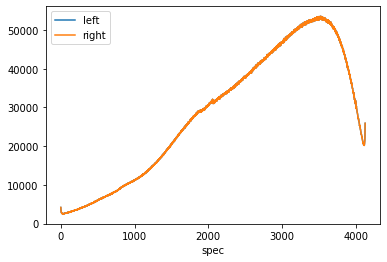

In [24]:
plt.clf()
ax = plt.gca()
ax.plot(left_spec, label='left')
ax.plot(left_spec, label='right')
ax.legend()
ax.set_xlabel('spec')
plt.show()

In [20]:
rtio_spec = left_spec/right_spec

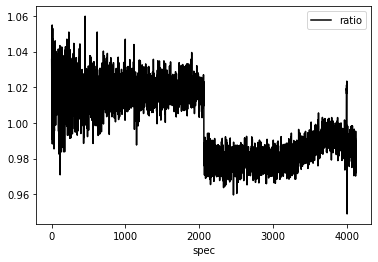

In [34]:
plt.clf()
ax = plt.gca()
ax.plot(rtio_spec, label='ratio', color='k')
#ax.plot(left_spec, label='right')
ax.set_xlabel('spec')
ax.legend()
plt.savefig('ratio_spec.png', dpi=300)
plt.show()

## Spatial cuts

In [25]:
spec_mid = flatImages.pixelflat_raw.shape[0]//2
spec_mid

2064

In [26]:
bot_spat = np.median(flatImages.pixelflat_raw[spec_mid-3:spec_mid, :], axis=0)
top_spat = np.median(flatImages.pixelflat_raw[spec_mid:spec_mid+3, :], axis=0)

In [27]:
rtio_spat = top_spat/bot_spat

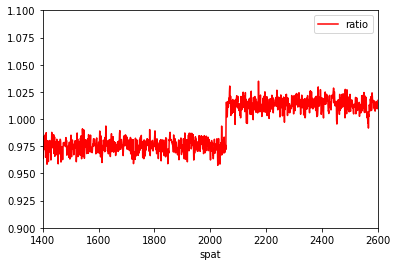

In [35]:
plt.clf()
ax = plt.gca()
ax.plot(rtio_spat, label='ratio', color='r')
#ax.plot(left_spec, label='right')
ax.set_xlabel('spat')
ax.set_xlim(1400, 2600)
ax.set_ylim(0.9, 1.1)
ax.legend()
plt.savefig('ratio_spat.png', dpi=300)

plt.show()